# Motif Refinement
---
Draft motifs identified from an IGR can be refined using this sheet by performing iterative searches taking predicted secondary structure into account.

**Recommended: Restart kernel every time you are working on a new set of data.

## Step 0. Import Necessary Code
---
Python has basic functions, but to do more advanced functions we need to import additional python packages. The last two lines (from src…) are importing code that is specific and unique to dimpl.


In [1]:
%cd /home/jovyan/work

import sys
import os
import shutil
import pandas as pd
import glob
import tarfile
from Bio import AlignIO, SeqIO
import subprocess
import pandas as pd
import ipywidgets

from src.data.genome_context import get_all_images, run_rscape, tar_subdir_members, build_target_coords
from src.data.command_build import build_infernal_commands

/home/jovyan/work


## Step 1. Set up folders and drop in .sto files
---
Create a new directory under data/motif_collections.

Create a subdirectory in that new directory with a name for the analysis step (e.g. infernal_step2). Folder/subfolder architecture is required, but folder names can be whatever you want.

Finally, create a directory in the the step directory named "motifs". Place all the .sto files of interest in that directory.

Change the variables in the codeblock below to reflect the collection_name directory and the step directory you just created.

In [2]:
# Change the variables below
collection_name = "riboswitch_candidates"
step_name = "infernal_step2"

In [3]:
# Will move any .sto files found in the data_dir to the /motifs folder
data_dir = "data/motif_collections/{}".format(collection_name)
step_dir = "{}/{}".format(data_dir, step_name)
search_dir = "{}/motifs".format(step_dir)
sto_files = glob.glob("{}/*.sto".format(search_dir))
for sto_file in sto_files:
    motif_name = sto_file[sto_file.rfind('/')+1:-4]
    motif_folder = "{}/{}".format(step_dir, motif_name)
    if not os.path.exists(motif_folder):
        os.mkdir(motif_folder)
    shutil.copyfile(sto_file, "{}/{}.sto".format(motif_folder, motif_name))

# Build the collection of commands required for infernal
build_infernal_commands(data_dir, step_name)
tarfilename = "{}_{}".format(collection_name, step_name)
with tarfile.open("data/export/{}.tar.gz".format(tarfilename), "w:gz") as tar:
    tar.add(data_dir, arcname=tarfilename)
    

## Step 2. Run code on cluster
---
Move Tarfile to your high-performance cluster. Tarfile is located in data/export.
If you typically log into cluster using `ssh`, you'll be able to use `scp` to do the file transfer. Example command: `scp /path/to/dimpl/data/export/tarfilename.tar.gz netid@farnam.hpc.yale.edu:~/project/wherever`.

Untar the uploaded file by using the command `tar xzvf tarfilename`. Remove tarfile using `rm tarfilename.tar.gz` (unpacked files will remain).

Run the script named stepname_run.sh in the newly extracted folder by entering `./stepname_run.sh` into the terminal. If you get a permissions error, run `chmod +x stepname_run.sh` and then try again.

You can monitor completion of the analysis using the command `squeue -u username` to see running tasks. (PD = pending, R = running)

## Step 3. Compress results
---
When analysis is complete, compress the results of the analysis on the computational cluster using the command:

`./make_tar.sh`

## Step 4. Move results from cluster to dimpl
---
Place the downloaded tar.gz file in data/import directory of the DIMPL's file architecture.

Example command: `scp netid@farnam.hpc.yale.edu:~/path/to/tarfile/collection_name_step_name.done.tar.gz /path/to/dimpl/data/import`.

## Step 5. Prep data import
---
Change the variable `import_tar_name`, `collection_name` and `step_name` below to reflect the data being imported.

In [4]:
# Change the variables here to reflect data being imported
import_tar_name = "data/import/riboswitch_candidates_infernal_step2.tar.gz"
import_collection_name = "riboswitch_candidates"
import_step_name = "infernal_step2"

# Unpack the files 
untar_dir = "data/motif_collections/{}".format(import_collection_name)        
with tarfile.open(import_tar_name, "r:gz") as tar:
    tar.extractall(path=untar_dir, members=tar_subdir_members(tar, import_tar_name))    print("\nTarfile created:",tar.name)

### Collect all the potential motifs in the imported directory and generate selection dropdown

In [5]:
data_dir = "{}/{}".format(untar_dir, import_step_name)
tblout_files = glob.glob("{}/*/*.tblout".format(data_dir))        
motif_list = list(file.split('/')[-1][:-10] for file in tblout_files)
motif_dropdown = ipywidgets.Dropdown(options=motif_list, description="Motif Name",  layout={'width': 'max-content'})
motif_dropdown

Dropdown(description='Motif Name', layout=Layout(width='max-content'), options=('FINAL_cleanup-purF_nodupe', '…

## Step 6. Analysis
---
After selecting an IGR from the dropdown below, run cells starting at this codeblock to generate the analysis data.

In [6]:
# Saves the next motif in the list of motifs to motif_name
motif_name=motif_dropdown.value
outdir="{}/{}".format(data_dir,motif_name)
sto_filename = "{}/{}.cm.align.sto".format(outdir, motif_name)
dedupe_filename = "{}/{}.dedupe.fasta".format(outdir, motif_name)
sample_filename = "{}/{}.sample.fasta".format(outdir, motif_name)
results_filename ="{}/{}.cm.tblout".format(outdir, motif_name) 

# Read in the results from the .tblout file
results_df = pd.read_csv(results_filename, skiprows=2, skipfooter=10, sep='\s+', engine='python', header=None, 
                         names=['target_name', 'target_accession', 'query_name', 'query_accession', 'mdl', 'mdl_from', 'mdl_to', 
                                'seq_from', 'seq_to', 'strand', 'trunc', 'pass', 'gc', 'bias', 'score', 'e_value', 'inc','description'])
# Correct coordinates taking IGR database into account
results_df['target_coords'] = results_df.apply(lambda row: build_target_coords(row['target_name'], row['seq_from'], row['seq_to']), axis=1)
results_df.drop(columns=['target_accession', 'query_accession', 'inc', 'description', 'query_name'], inplace=True)

# Remove duplicate entries from the database
dedupe_fasta = list(SeqIO.parse(dedupe_filename, 'fasta'))
dedupe_id_list = [(record.id) for record in dedupe_fasta]
deduped_results_df = results_df[results_df['target_coords'].isin(dedupe_id_list)]

# Output results
print("Results for: {}".format(motif_name))
print("Number of Unique Hits: {}".format(len(dedupe_id_list)))

# Display up to 100 rows
with pd.option_context('display.max_rows', 100):
    display(deduped_results_df[['e_value', 'target_coords', 'gc', 'bias', 'score', 'strand', ]])

Results for: purF-consensus
Number of Unique Hits: 20


,e_value,target_coords,gc,bias,score,strand
0,4.700000e-20,NZ_MWQH01000009.1/99186-99274,0.57,0.0,106.3,+
3,9.600000e-20,NZ_FRBA01000001.1/181754-181842,0.54,0.0,105.2,+
5,2.300000e-19,NZ_OCSS01000001.1/328719-328807,0.57,0.0,103.8,+
9,5.300000e-19,NZ_FRCW01000015.1/7701-7789,0.52,0.0,102.4,+
10,1.300000e-18,NC_013410.1/50003-50091,0.53,0.0,100.9,+
12,9.200000e-18,NZ_FRAY01000004.1/380161-380249,0.53,0.0,97.8,+
13,2.400000e-17,NZ_FSRT01000002.1/322058-322145,0.49,0.0,96.2,+
14,2.700000e-17,NZ_MWQE01000002.1/249172-249260,0.54,0.0,96.1,+
15,4.600000e-17,NZ_MWQK01000008.1/16416-16503,0.48,0.0,95.2,+
19,5.100000e-17,NZ_FRCO01000002.1/809474-809561,0.64,0.0,95.0,+


### 6.1 RNAcode Analysis for Possible Protein Coding Regions

Regions with a p-value < 0.05 are indicative of protein coding regions. SVG images of any such regions will be placed in the motif subfolder.

In [7]:
clustal_filename = "{}/{}/{}.sample.clustal".format(data_dir,motif_name, motif_name) 

sample_fasta = list(SeqIO.parse(sample_filename, 'fasta'))
sample_id_list = [record.id for record in sample_fasta]
sto_records = list(SeqIO.parse(sto_filename, 'stockholm'))
sampled_sto_records = [record for record in sto_records if record.id in sample_id_list]

alignment = sampled_sto_records[:200]

with open(clustal_filename, 'w') as clustal_file:
    SeqIO.write(alignment, clustal_file, "clustal")
    
output = subprocess.run(['RNAcode', clustal_filename], capture_output=True)

print(output.stdout.decode())
print(output.stderr.decode())


 HSS # Frame Length  From    To        Name       Start         End    Score        P
     0    -3     12    16    27NZ_MWQH01000009.1/99186-99274          48          83     9.62    0.157
     1    -2     19     8    26NZ_MWQH01000009.1/99186-99274          23          79     5.91    0.662
     2    +1      4    19    22NZ_MWQH01000009.1/99186-99274          55          66     4.07    0.934
     3    +2      9     3    11NZ_MWQH01000009.1/99186-99274           8          34     2.75    0.995
     4    +3      4    24    27NZ_MWQH01000009.1/99186-99274          72          83     2.00    0.999
     5    +1      3     9    11NZ_MWQH01000009.1/99186-99274          25          33     1.79    1.000
     6    -1      6     1     6NZ_MWQH01000009.1/99186-99274           1          18     1.26    1.000
     7    +1      3    27    29NZ_MWQH01000009.1/99186-99274          79          87     0.51    1.000

1 alignment(s) scored in 0.38 seconds. Parameters used:
N=100, Delta=-10.00, Omega=-4.00

## 6.2 R-scape De-Novo Structure Prediction

When fold=true, will use predictive mode to build the best consensus structure with the largest possible number of significantly covarying pairs, including predicting psuedoknots.

After running the code block, a preview of the generated .svg will appear, containing the consensus and any predicted pseudoknots. An SVG images will be placed in the motif subfolder.

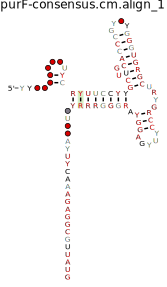

In [8]:
# change output=True to see R-scape table
run_rscape(outdir, sto_filename, fold=True, output=False)

## 6.3 CMfinder Realigned Structure

CMFinder outputs its best folding prediction as a file ending in `cmfinder.realign.sto`. This codeblock will run that realign file through R-scape to evaluate a the structure for covariation. Because fold=False, it will not find psuedoknots unless they were already predicted in the structure.

After running the code a preview of the generated .svg will appear. An SVG image will be placed in the motif subfolder.

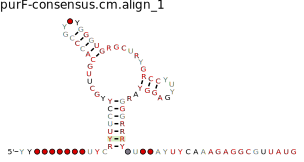

In [9]:
# change output=False to see R-scape table
realign_filename = "{}/{}.cmfinder.realign.sto".format(outdir, motif_name)
run_rscape(outdir, realign_filename, fold=False, output=False)

## 6.4 CMfinder Analyzed Submotifs

CMFinder will often generate several submotifs and use the submotifs to find the 'best' version and output it as the `cmfinder.realign.sto` file.

Running this code will show you all submotifs. SVG images for each submotif will be placed in the motif subfolder.

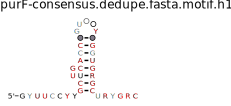

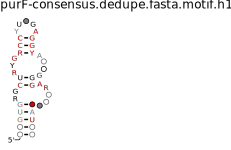

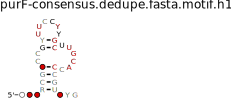

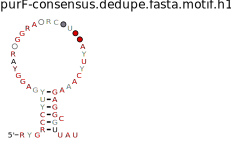

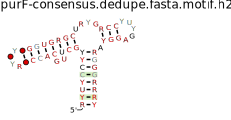

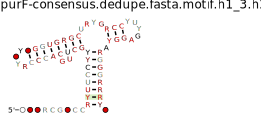

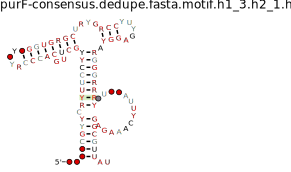

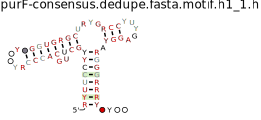

In [10]:
with open("{}/motif.list".format(outdir), "r") as motif_list_file:
    motif_list = motif_list_file.read().split('\n')
    
motif_list.remove("")
motif_list = ["{}/{}".format(untar_dir,motif) for motif in motif_list ]
for file in motif_list:
    renamed_file = "{}.sto".format(file)
    if not os.path.isfile(renamed_file):
        os.rename(file, renamed_file)
    run_rscape(outdir, renamed_file, fold=False, output=False)

## 6.5 Genome Context Images

Generates list of genome context images for each unique hit. RNA motif is shown in blue, genes are shown in purple or red depending on directionality.

Your match numbers may 'skip' (i.e. jumps from #1 to #4) - those missing are duplicates and were removed.

Match #1
E-value: 4.7e-20
%GC: 0.57
Score: 106.3
Genome Assembly: GCF_002210295.1_ASM221029v1
Target: NZ_MWQH01000009.1/99186-99274
Lineage: cellular organisms; Bacteria; FCB group; Fibrobacteres; Fibrobacteria; Fibrobacterales; Fibrobacteraceae; Fibrobacter; unclassified Fibrobacter
Matched Sequence: ACAAGGGCGGCCGCUUCCUUGCUUGCACCCGUCUGGGUGGGCUGUGACCUUCGAGGUAGGGGAAGCAUACAUUUCAAAGAGGCGUUAUG


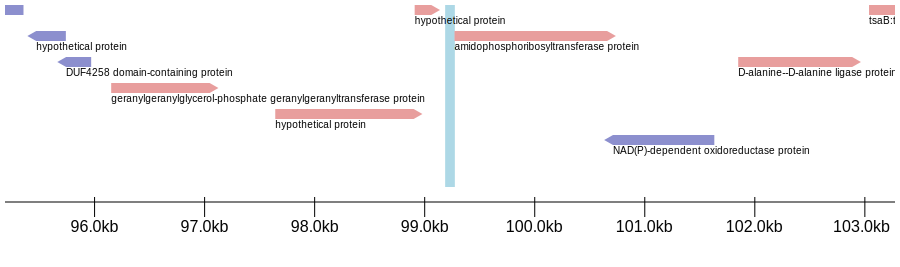

Match #4
E-value: 9.6e-20
%GC: 0.54
Score: 105.2
Genome Assembly: GCF_900142495.1_IMG-taxon_2700988684_annotated_assembly
Target: NZ_FRBA01000001.1/181754-181842
Lineage: cellular organisms; Bacteria; FCB group; Fibrobacteres; Fibrobacteria; Fibrobacterales; Fibrobacteraceae; Fibrobacter; unclassified Fibrobacter
Matched Sequence: ACAAGGGCGGCUGUUUCCUUGCUUGCACCCGUCCGGGUGGGCUAUGACCUUCGAGGUAGAGGGAACAUACAUUUCAAAGAGGCGUUAUG


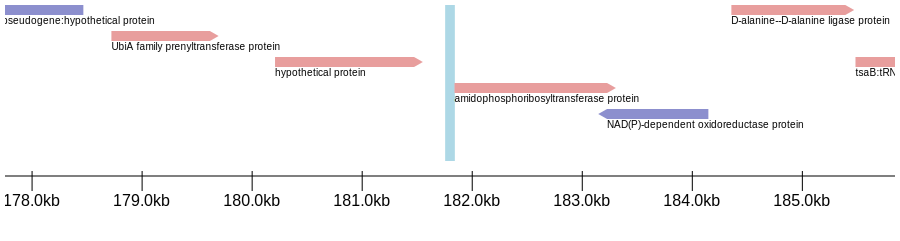

Match #6
E-value: 2.3e-19
%GC: 0.57
Score: 103.8
Genome Assembly: GCF_900230125.1_IMG-taxon_2738541339_annotated_assembly
Target: NZ_OCSS01000001.1/328719-328807
Lineage: cellular organisms; Bacteria; FCB group; Fibrobacteres; Fibrobacteria; Fibrobacterales; Fibrobacteraceae; Fibrobacter; unclassified Fibrobacter
Matched Sequence: CCUGGCGCGUCCGUUUCCCUGCUUGCACCCGAACGGGUGGGCUAUGACCUUCGAGGUAGGGGAGACAUAAAUUUCAGAGAGGCGUUAUG


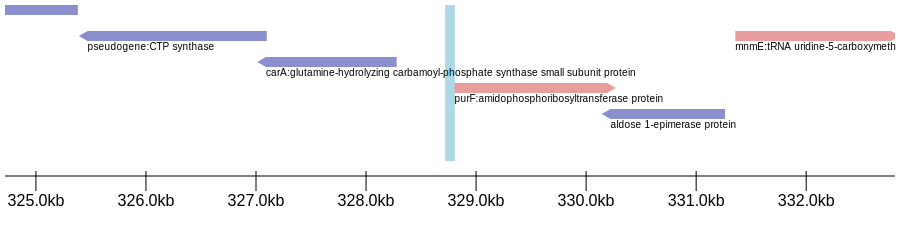

Match #10
E-value: 5.3e-19
%GC: 0.52
Score: 102.4
Genome Assembly: GCF_900143055.1_IMG-taxon_2703719264_annotated_assembly
Target: NZ_FRCW01000015.1/7701-7789
Lineage: cellular organisms; Bacteria; FCB group; Fibrobacteres; Fibrobacteria; Fibrobacterales; Fibrobacteraceae; Fibrobacter; unclassified Fibrobacter
Matched Sequence: CCAAAAACGUCCGUUUCCCUGCUUGCAUCCGAACGGGUGGGCUGUGACCUUCGAGGUAGGGGAAACAUAAAUUUCAGAGAGGCGUUAUG


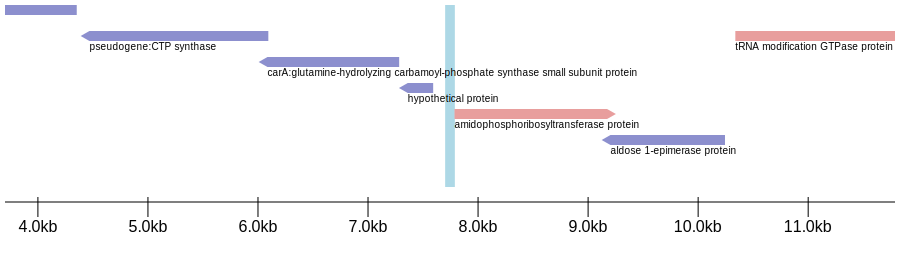

Match #11
E-value: 1.3000000000000002e-18
%GC: 0.53
Score: 100.9
Genome Assembly: GCF_000024665.1_ASM2466v1
Target: NC_013410.1/50003-50091
Lineage: cellular organisms; Bacteria; FCB group; Fibrobacteres; Fibrobacteria; Fibrobacterales; Fibrobacteraceae; Fibrobacter; Fibrobacter succinogenes; Fibrobacter succinogenes subsp. succinogenes
Matched Sequence: CCUAUGCGGUCCACUUCUCCGCUUGCACCCGUAUGGGUGAGCUACGGCCUUCGAGGCAAGGGAAGUAUUCAUUUCAAAGAGGCUUUAUG


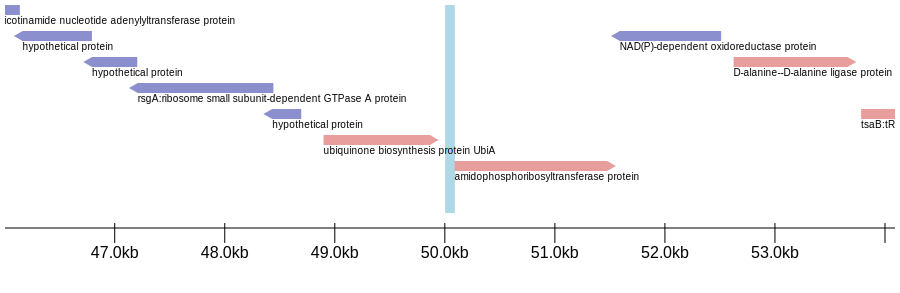

Match #13
E-value: 9.2e-18
%GC: 0.53
Score: 97.8
Genome Assembly: GCF_900142475.1_IMG-taxon_2700988680_annotated_assembly
Target: NZ_FRAY01000004.1/380161-380249
Lineage: cellular organisms; Bacteria; FCB group; Fibrobacteres; Fibrobacteria; Fibrobacterales; Fibrobacteraceae; Fibrobacter; unclassified Fibrobacter
Matched Sequence: UUUGCCUUGUUCGCUUUCCCGCUUGCACCCAUACGGGUGGGCAAUGACCAUCGAGGUAAGGAAAGCACACAUUCCAGAGAGGCGUUAUG


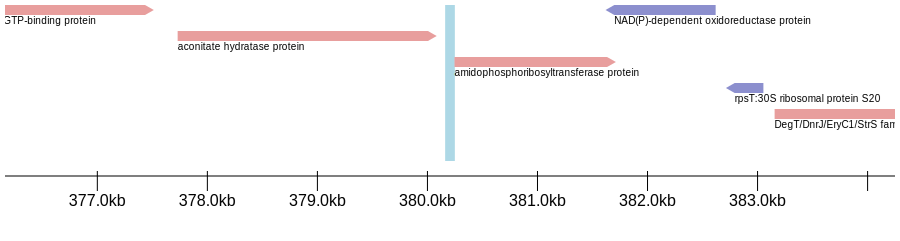

Match #14
E-value: 2.4e-17
%GC: 0.49
Score: 96.2
Genome Assembly: GCF_900143015.1_IMG-taxon_2703719254_annotated_assembly
Target: NZ_FSRT01000002.1/322058-322145
Lineage: cellular organisms; Bacteria; FCB group; Fibrobacteres; Fibrobacteria; Fibrobacterales; Fibrobacteraceae; Fibrobacter; unclassified Fibrobacter
Matched Sequence: UAAAAUUCGUCCGUUUCCUCGCUUGCACCCGUCCGGGUGGGCUAUGACCAUAAGGUAAGGGAAACAUCCAUUCACAAGAGGCAUUAUG


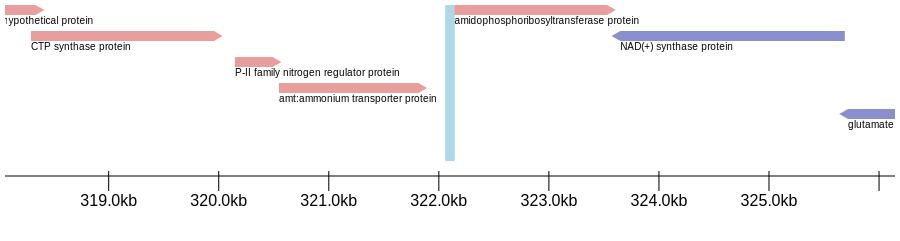

Match #15
E-value: 2.7e-17
%GC: 0.54
Score: 96.1
Genome Assembly: GCF_002210285.1_ASM221028v1
Target: NZ_MWQE01000002.1/249172-249260
Lineage: cellular organisms; Bacteria; FCB group; Fibrobacteres; Fibrobacteria; Fibrobacterales; Fibrobacteraceae; Fibrobacter; unclassified Fibrobacter
Matched Sequence: UUUCCGCGUUCCGCUUCCCUGCUUGCAUCCGUACGGAUGGGCUGUGACCUUCGAGGUAGGGGAGGCUUAAAAUUCAAAGAGGCGAUAUG


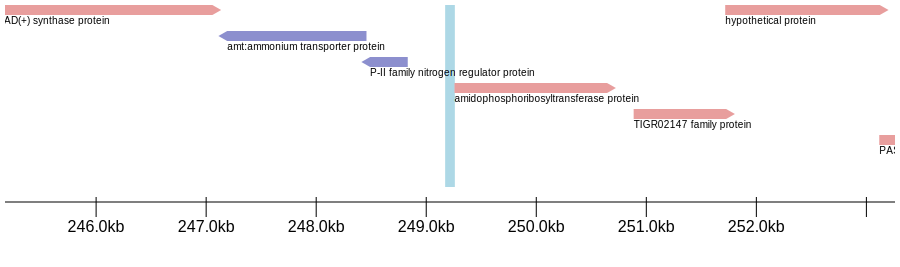

Match #16
E-value: 4.6e-17
%GC: 0.48
Score: 95.2
Genome Assembly: GCF_002210425.1_ASM221042v1
Target: NZ_MWQK01000008.1/16416-16503
Lineage: cellular organisms; Bacteria; FCB group; Fibrobacteres; Fibrobacteria; Fibrobacterales; Fibrobacteraceae; Fibrobacter; unclassified Fibrobacter
Matched Sequence: UAAAAUUCGUCCGUUUCCUCGCUUGCACCCGUCCGGGUGGGCUAUGACCAAAAGGUAAGGGAAACAUCCAUUCAUAAGAGGCAUUAUG


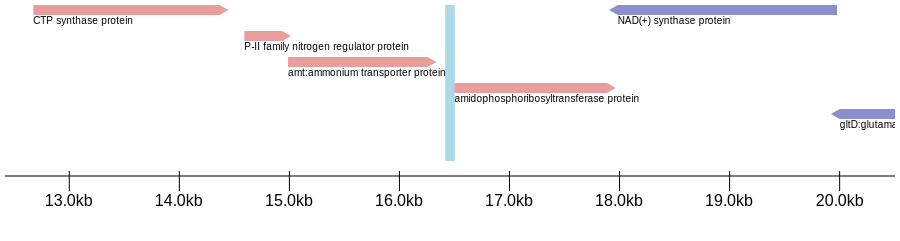

Match #20
E-value: 5.1e-17
%GC: 0.64
Score: 95.0
Genome Assembly: GCF_900142945.1_IMG-taxon_2703719236_annotated_assembly
Target: NZ_FRCO01000002.1/809474-809561
Lineage: cellular organisms; Bacteria; FCB group; Fibrobacteres; Fibrobacteria; Fibrobacterales; Fibrobacteraceae; Fibrobacter; unclassified Fibrobacter
Matched Sequence: UCCGCGGCGUCCGCUUCCCCGCUUGCACCCGUAUGGGUGAGCUAAGGCCCUCGAGGCAAGGGAGGCUCCACUUCAAAGAGGCGUUAUG


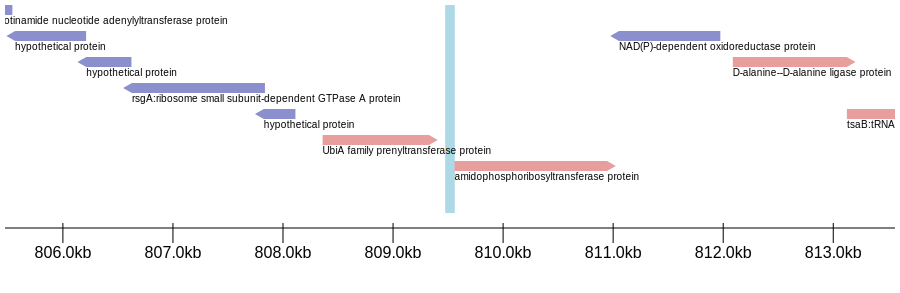

Match #25
E-value: 1.1e-15
%GC: 0.55
Score: 90.0
Genome Assembly: GCF_900142535.1_IMG-taxon_2700988688_annotated_assembly
Target: NZ_FRBE01000005.1/5625-5713
Lineage: cellular organisms; Bacteria; FCB group; Fibrobacteres; Fibrobacteria; Fibrobacterales; Fibrobacteraceae; Fibrobacter; unclassified Fibrobacter
Matched Sequence: UCUAGCCGCUUGAUUCUCUCGCUUGCACCGGUUCCGGUGAGCUACGGCCCUCGAGGCAGGGAGAAUUUCAUUUCCAAAGAGGCGUUAUG


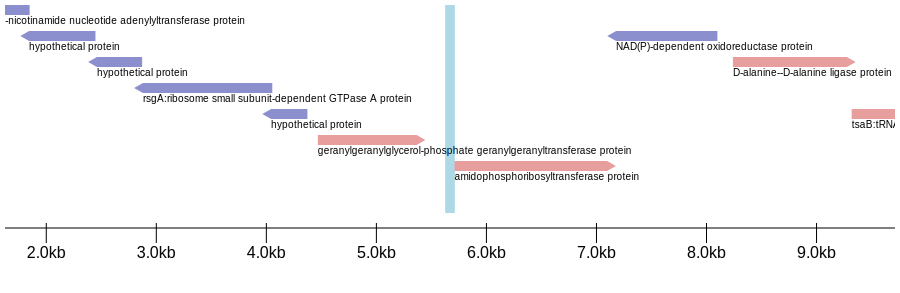

Match #28
E-value: 1.3999999999999999e-14
%GC: 0.64
Score: 86.0
Genome Assembly: GCF_002210345.1_ASM221034v1
Target: NZ_MWQI01000008.1/165154-165241
Lineage: cellular organisms; Bacteria; FCB group; Fibrobacteres; Fibrobacteria; Fibrobacterales; Fibrobacteraceae; Fibrobacter; unclassified Fibrobacter
Matched Sequence: UCCGCGGCGUCCGCUUCCCGGCUUGCACCCGUUUCGGUGAGCUAAGGCCCUCGAGGCAAGGGAGGCUCCACUUCAAAGAGGCGUUAUG


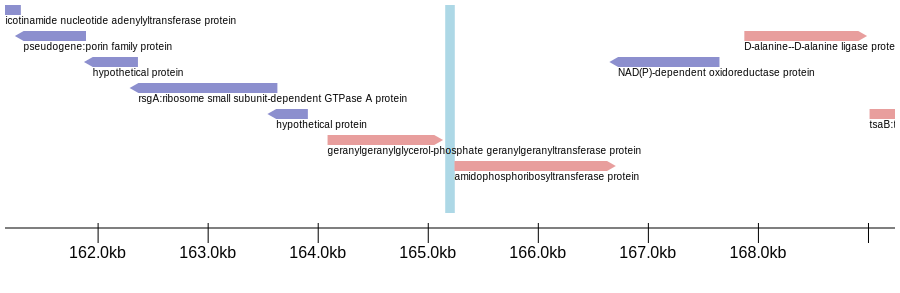

In [11]:
deduped_sto_records = [record for record in sto_records if record.id in dedupe_id_list]
results_csv_filename = "{}/{}_results.csv".format(outdir, motif_name)
if not os.path.exists(results_csv_filename):
    deduped_results_df['lineage']=''
    deduped_results_df['assembly_accession']=''
    deduped_results_df.to_csv(results_csv_filename)
get_all_images(results_csv_filename, deduped_sto_records)